## Setup and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import permutations
from pathlib import Path
from genometechlab_plotting import setup_style, get_colors
setup_style("inline")
colors = get_colors()

Loaded 7 Helvetica fonts


## Mod Codes

In [2]:
# Modification code mapping
MOD_MAPPING = {
    'a': 'm6A',      
    '17802': 'Psi', 
    '17596': 'Ino',
    'm': 'm5C'
}

VALID_MODS = set(MOD_MAPPING.keys())

## Analysis

In [3]:
def eligible_mods(sub_df, min_distance=5):
    """Identify modifications that are at least min_distance bp apart from neighbors"""
    gapped_mods = set()
    mod_pos = [(pos, mod) for mod, pos in zip(sub_df["mod"].to_list(), sub_df["drs_start"].to_list())]
    
    if len(mod_pos) == 1:
        return set()
        
    if len(mod_pos) == 2:
        distance = abs(mod_pos[0][0] - mod_pos[1][0])
        if distance > min_distance:
            gapped_mods.add(mod_pos[0][1])
            gapped_mods.add(mod_pos[1][1])
        return gapped_mods
    
    # Check first modification
    dist_to_next = abs(mod_pos[0][0] - mod_pos[1][0])
    if dist_to_next > min_distance: 
        gapped_mods.add(mod_pos[0][1])
        
    # Check last modification
    dist_to_prev = abs(mod_pos[-1][0] - mod_pos[-2][0])
    if dist_to_prev > min_distance:
        gapped_mods.add(mod_pos[-1][1])
        
    # Check middle modifications
    for i in range(1, len(mod_pos) - 1):
        dist_to_prev = abs(mod_pos[i-1][0] - mod_pos[i][0])
        dist_to_next = abs(mod_pos[i][0] - mod_pos[i+1][0])
        
        if dist_to_prev > min_distance and dist_to_next > min_distance:
            gapped_mods.add(mod_pos[i][1])
    
    return gapped_mods

def px_given_y(mod_set, gene_mod_dict, y, x):
    """Calculate P(x|y) = probability of observing x given that y is present"""
    yes = 0
    no = 0
    total_x_positions = 0
    
    for gene_id, s in mod_set:
        if y in s:
            if x in s:
                yes += 1
                total_x_positions += gene_mod_dict[gene_id].get(x, 0)
            else:
                no += 1
    
    if yes + no == 0:
        return 0, 0, 0
    
    return yes / (yes + no), yes, total_x_positions

## Sample Processing

In [4]:
def process_sample(df_path, sample_name, min_distance=5):
    """Process a single sample and calculate co-occurrence"""
    
    print(f"\n{'='*50}")
    print(f"Processing: {sample_name}")
    print(f"{'='*50}")
    
    # Load data
    df = pd.read_pickle(df_path)
    print(f"Loaded {len(df):,} rows total")
    
    # Filter for only the four modifications
    df['mod'] = df['mod'].astype(str)
    df_filtered = df[df['mod'].isin(VALID_MODS)].copy()
    
    print(f"Kept {len(df_filtered):,} rows with target modifications")
    
    # Count each modification type
    print("\nModification Summary:")
    summary_data = []
    for mod_code, mod_name in sorted(MOD_MAPPING.items(), key=lambda x: x[1]):
        count = len(df_filtered[df_filtered['mod'] == mod_code])
        n_genes = df_filtered[df_filtered['mod'] == mod_code]['gene_id'].nunique()
        summary_data.append({
            'Sample': sample_name,
            'Modification': mod_name,
            'Total_Positions': count,
            'Total_Genes': n_genes
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    # Sort and process
    df_filtered.sort_values(by=["gene_id", "drs_start"], inplace=True)
    
    # Create dictionary to track modification counts per gene
    gene_mod_dict = {}
    gene_mod_sets = []
    
    for gene_id, sub_df in df_filtered.groupby("gene_id"):
        eligible = eligible_mods(sub_df, min_distance)
        if eligible:
            gene_mod_sets.append((gene_id, eligible))
            mod_counts = sub_df['mod'].value_counts().to_dict()
            gene_mod_dict[gene_id] = mod_counts
    
    print(f"\nGenes with eligible modifications: {len(gene_mod_sets)}")
    
    # Get all unique modifications
    all_mods = set()
    for gene_id, s in gene_mod_sets:
        all_mods.update(s)
    
    # Calculate co-occurrence probabilities
    mod_list = sorted(all_mods)
    co_obs_data = []
    
    for given_mod, observed_mod in permutations(mod_list, 2):
        co_obs, n_genes, n_positions = px_given_y(gene_mod_sets, gene_mod_dict, given_mod, observed_mod)
        
        given_label = MOD_MAPPING[str(given_mod)]
        observed_label = MOD_MAPPING[str(observed_mod)]
        
        co_obs_data.append({
            'Sample': sample_name,
            'Given_Mod': given_label,
            'Observed_Mod': observed_label,
            'P(Observed|Given)': co_obs,
            'Genes_With_Both': n_genes,
            'Observed_Positions': n_positions
        })
    
    co_obs_df = pd.DataFrame(co_obs_data)
    
    return co_obs_df, summary_df

## Plotting

In [5]:
def plot_cooccurrence_grouped(results_dict, summary_dict, output_path=None, save_plot=True):
    """Create co-occurrence plots grouped by observed modification"""
    
    n_samples = len(results_dict)
    if n_samples == 0:
        print("No data to plot!")
        return
    
    # Define colors for given modifications
    given_colors = {
        'm6A': colors[0] if len(colors) > 0 else '#1f77b4',
        'Psi': colors[1] if len(colors) > 1 else '#ff7f0e',
        'Ino': colors[2] if len(colors) > 2 else '#2ca02c',
        'm5C': colors[3] if len(colors) > 3 else '#d62728'
    }
        
    if n_samples == 1:
        fig, ax = plt.subplots(figsize=(12, 6))
        axes = [ax]
    else:
        fig, axes = plt.subplots(1, n_samples, sharey=True, figsize=(6*n_samples, 6))
        if n_samples == 2:
            axes = list(axes)
    
    for idx, (sample_name, results) in enumerate(results_dict.items()):
        ax = axes[idx] if n_samples > 1 else axes[0]
        
        # Group data by observed mod
        observed_mods = sorted(results['Observed_Mod'].unique())
        given_mods = sorted(results['Given_Mod'].unique())
        
        n_observed = len(observed_mods)
        n_given = len(given_mods)
        bar_width = 0.8 / n_given
        x_pos = np.arange(n_observed)
        
        # Plot bars for each given mod
        for i, given_mod in enumerate(given_mods):
            values = []
            annotations = []
            for obs_mod in observed_mods:
                mask = (results['Given_Mod'] == given_mod) & (results['Observed_Mod'] == obs_mod)
                val = results[mask]['P(Observed|Given)'].values
                n_genes = results[mask]['Genes_With_Both'].values
                n_pos = results[mask]['Observed_Positions'].values
                
                if len(val) > 0:
                    values.append(val[0])
                    annotations.append((n_genes[0], n_pos[0]))
                else:
                    values.append(0)
                    annotations.append((0, 0))
            
            offset = (i - n_given/2 + 0.5) * bar_width
            bars = ax.bar(x_pos + offset, values, bar_width,
                  label=f"Given {given_mod}" if idx == 0 else "",
                  color=given_colors.get(given_mod, 'gray'),
                  edgecolor='black', linewidth=0.5)
            
            # Add annotations
            for j, (bar, (n_genes, n_pos)) in enumerate(zip(bars, annotations)):
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{n_genes}g\n{n_pos}p',
                           ha='center', va='bottom', fontsize=7)
        
        # Customize subplot
        ax.set_xlabel('Observed Modification')
        ax.set_ylabel('P(Observed | Given)' if idx == 0 else '')
        ax.set_title(f'{sample_name}')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(observed_mods)
        ax.set_ylim(0, 1.15)
        ax.grid(axis='y', alpha=0.3)
        
        if idx == 0:
            ax.legend(title='Given Mod', loc='upper left')
    
    if save_plot and output_path:
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\nPlot saved to: {output_path}")
        
        # Save tables
        base_name = Path(output_path).stem
        output_dir = Path(output_path).parent
        
        # Save co-occurrence table
        cooccurrence_table = pd.concat(results_dict.values(), ignore_index=True)
        cooccurrence_path = output_dir / f"{base_name}_cooccurrence.csv"
        cooccurrence_table.to_csv(cooccurrence_path, index=False)
        print(f"Co-occurrence table saved to: {cooccurrence_path}")
        
        # Save summary table
        summary_table = pd.concat(summary_dict.values(), ignore_index=True)
        summary_path = output_dir / f"{base_name}_summary.csv"
        summary_table.to_csv(summary_path, index=False)
        print(f"Summary table saved to: {summary_path}")
    else:
        plt.show()
    
    return fig

## Paths

In [6]:
# Configuration
INPUT_FILES = ['../Exemplar_Data/annotated_output/pickle_output/08_07_24_GM12878_chr12-112000000-114000000_annotated_valid_kmer.pkl']  # List of pickle files
SAMPLE_NAMES = None  # Optional: custom names for samples (None = auto from filename)
OUTPUT_PATH = './cooccurrence_plot.pdf'  # Output path for plots
MIN_DISTANCE = 5  # Minimum distance between modifications (bp)
SAVE_PLOTS = False  # Set to False to only display plots


## Run Analysis


Processing: 08_07_24_GM12878_chr12-112000000-114000000
Loaded 172 rows total
Kept 165 rows with target modifications

Modification Summary:
                                    Sample Modification  Total_Positions  Total_Genes
08_07_24_GM12878_chr12-112000000-114000000          Ino               14            8
08_07_24_GM12878_chr12-112000000-114000000          Psi                2            2
08_07_24_GM12878_chr12-112000000-114000000          m5C               44           12
08_07_24_GM12878_chr12-112000000-114000000          m6A              105           16

Genes with eligible modifications: 16


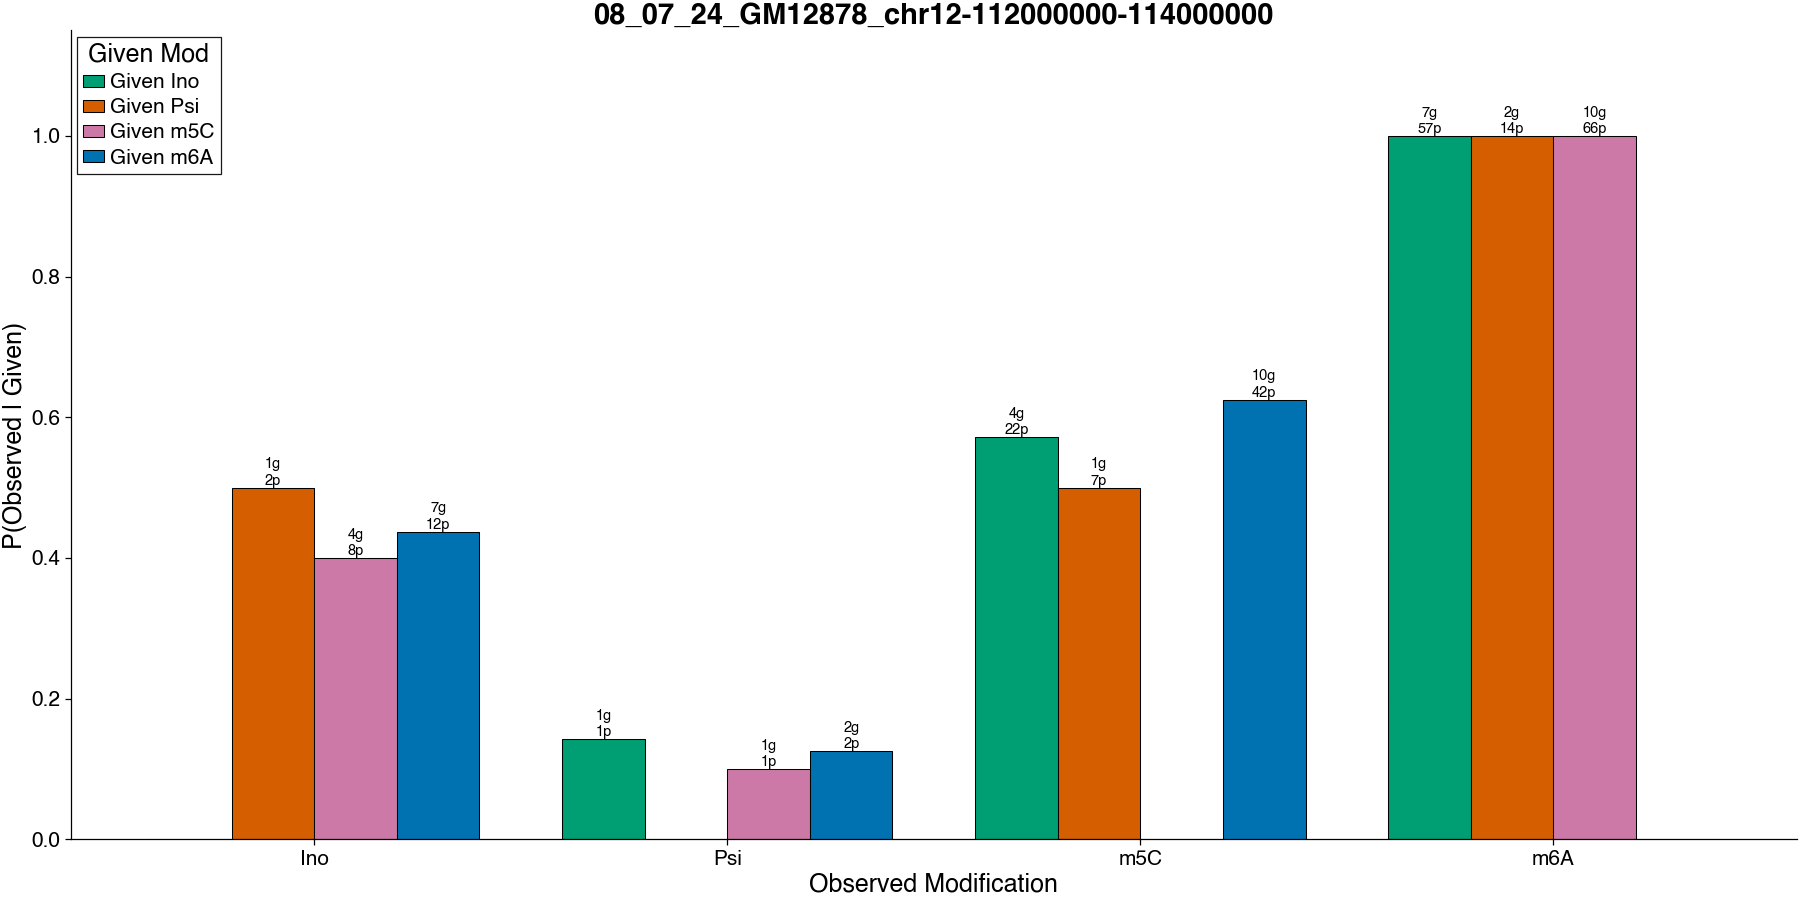


Co-occurrence Results:
                                        Sample Given_Mod Observed_Mod  P(Observed|Given)  Genes_With_Both  Observed_Positions
0   08_07_24_GM12878_chr12-112000000-114000000       Ino          Psi           0.142857                1                   1
1   08_07_24_GM12878_chr12-112000000-114000000       Ino          m6A           1.000000                7                  57
2   08_07_24_GM12878_chr12-112000000-114000000       Ino          m5C           0.571429                4                  22
3   08_07_24_GM12878_chr12-112000000-114000000       Psi          Ino           0.500000                1                   2
4   08_07_24_GM12878_chr12-112000000-114000000       Psi          m6A           1.000000                2                  14
5   08_07_24_GM12878_chr12-112000000-114000000       Psi          m5C           0.500000                1                   7
6   08_07_24_GM12878_chr12-112000000-114000000       m6A          Ino           0.437500      

In [7]:
%matplotlib inline
# Process all samples
results_dict = {}
summary_dict = {}

for idx, input_path in enumerate(INPUT_FILES):
    input_path = Path(input_path)
    
    if not input_path.exists():
        print(f"Warning: File not found - {input_path}")
        continue
    
    # Determine sample name
    if SAMPLE_NAMES and idx < len(SAMPLE_NAMES):
        sample_name = SAMPLE_NAMES[idx]
    else:
        sample_name = input_path.stem.replace('_annotated_valid_kmer', '')
    
    # Process sample
    results, summary = process_sample(input_path, sample_name, MIN_DISTANCE)
    
    if results is not None and len(results) > 0:
        results_dict[sample_name] = results
        summary_dict[sample_name] = summary

# Create plots
if results_dict:
    plot_cooccurrence_grouped(results_dict, summary_dict, OUTPUT_PATH, save_plot=SAVE_PLOTS)
else:
    print("No valid data to plot!")

# View co-occurrence table
if results_dict:
    cooccurrence_df = pd.concat(results_dict.values(), ignore_index=True)
    print("\nCo-occurrence Results:")
    print(cooccurrence_df.to_string())